In [1]:
#numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
import numpy as np
from jax import custom_jvp
from jax import custom_vjp
from jax import grad
from jax import vmap

この例では、phaseとノイズレベルsigmaを推定します。観測値はy=sin(x + phase)です。

In [2]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

In [3]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc1.pdf")

In [11]:
@custom_jvp
def f(x, phase):
    return jnp.sin(x+phase) 

@f.defjvp
def f_jvp(primals, tangents):
    x, phase = primals
    x_dot, phase_dot = tangents
    primal_out = f(x, phase)
    tangent_out = jnp.cos(x+phase) * x_dot + phase_dot * jnp.cos(x+phase)
    return primal_out, tangent_out

In [6]:
@custom_vjp
def h(x, phase):
    return jnp.sin(x+phase)

def h_fwd(x, phase):
    # Returns primal output and residuals to be used in backward pass by f_bwd.
    return h(x, phase), jnp.cos(x+phase)

def h_bwd(res, u):
    cos_xp = res # Gets residuals computed in f_fwd
    return (cos_xp * u,cos_xp * u)
   
h.defvjp(h_fwd, h_bwd)

In [12]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    phase = numpyro.sample('phase', dist.Uniform(-1.0*jnp.pi, 1.0*jnp.pi))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    #vh=vmap(f, (0, None), 0)
    vh=vmap(h, (0, None), 0)

    mu=vh(x,phase)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [13]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=y)
mcmc.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]


TypeError: mul got incompatible shapes for broadcasting: (2,), (21,).

In [137]:
samples = mcmc.get_samples()
samples["phase"]

DeviceArray([0.4263508 , 0.41143754, 0.31759807, ..., 0.41209742,
             0.3269439 , 0.27890587], dtype=float32)

In [138]:
import arviz
arviz.plot_trace(mcmc, var_names=["phase","sigma"])
plt.savefig("hmc2.pdf")

ModuleNotFoundError: No module named 'netCDF4'

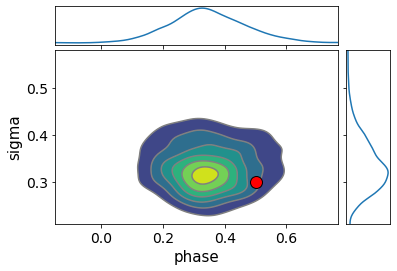

In [8]:
refs={};refs["sigma"]=sigin;refs["phase"]=phase
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("hmc3.pdf", bbox_inches="tight", pad_inches=0.0)

In [9]:
posterior_phase = mcmc.get_samples()['phase']
posterior_sigma = mcmc.get_samples()['sigma']

In [10]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma},return_sites=["y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

In [11]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


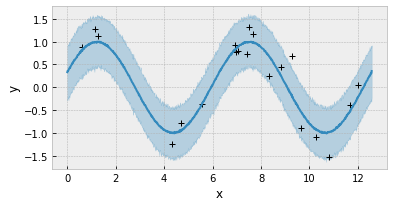

In [12]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc4.pdf")